In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../code-previous")

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import sklearn.feature_extraction as skfeatures
import utils
import time
import os

from unicodedata import category
from tqdm import tqdm
#from tqdm import tqdm_notebook as tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pylab as plt

import WOSutilities as wosutil

path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
data = pd.read_pickle("/mnt/disks/vault/citation-data-all/article-cat-c5-merged.pql")

Articles are only from Applied Physics category

In [5]:
data.columns

Index(['ArticleID', 'PubYear_x', 'Doctypes', 'Title', 'Type', 'Label',
       'PubYear_y', 'c5'],
      dtype='object')

In [6]:
years = data["PubYear_x"].unique()
years.sort()
years

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [7]:
# correction - adding 1 to all the citation counts (for easiness of log scale calculations)
# and taking the log scale on it
import numpy as np

data['log_c5'] = data['c5'].progress_apply(lambda x: np.log(x+1))

Progress: 100%|██████████| 39171597/39171597 [01:20<00:00, 488197.31it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5d6bdaa748>]],
      dtype=object)

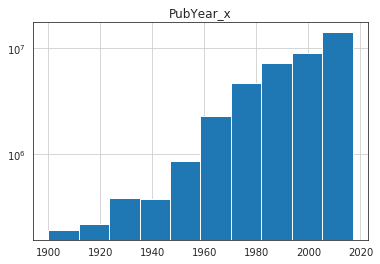

In [8]:
# number of publications
data.hist(column='PubYear_x', log=True)

In [9]:
len(data)

39171597

In [10]:
data.head()

,ArticleID,PubYear_x,Doctypes,Title,Type,Label,PubYear_y,c5,log_c5
0,A1981LC59600003,1981,Article,SPORADIC LEGIONELLOSIS IN THE UNITED-STATES - ...,NaN,NaN,1981.0,48.0,3.891820
1,A1981LC51800016,1981,Article,REACTION OF LEAD PERCHLORATE WITH AMMONIUM HYD...,NaN,NaN,1981.0,0.0,0.000000
2,A1981MP52000011,1981,Article,ELECTRICAL PACING FOR SHORT BOWEL SYNDROME,NaN,NaN,1981.0,5.0,1.791759
3,A1981LZ55900001,1981,Review,STABILITY TESTING OF SOLID DRUGS USING PREFERE...,NaN,NaN,1981.0,3.0,1.386294
4,A1981ME20500010,1981,Article,ON THE DETERMINATION OF THE 1ST NORMAL STRESS ...,NaN,NaN,1981.0,1.0,0.693147


In [11]:
len(data[data.Title == None])

0

In [12]:
# clean up puctuations from titles
sample = data.head(100)

# there are some titles with some problems - to be identified
def remove_punct(s):
    op = ''
    try:
        op = ''.join(ch for ch in str(s) if category(ch)[0] != 'P')
    except:
        op = ''
    return op
    
    

data['title_without_punctuations'] = data['Title'].progress_apply(lambda x: remove_punct(x))

Progress: 100%|██████████| 39171597/39171597 [11:44<00:00, 55565.59it/s]


In [13]:
data.head()

,ArticleID,PubYear_x,Doctypes,Title,Type,Label,PubYear_y,c5,log_c5,title_without_punctuations
0,A1981LC59600003,1981,Article,SPORADIC LEGIONELLOSIS IN THE UNITED-STATES - ...,NaN,NaN,1981.0,48.0,3.891820,SPORADIC LEGIONELLOSIS IN THE UNITEDSTATES TH...
1,A1981LC51800016,1981,Article,REACTION OF LEAD PERCHLORATE WITH AMMONIUM HYD...,NaN,NaN,1981.0,0.0,0.000000,REACTION OF LEAD PERCHLORATE WITH AMMONIUM HYD...
2,A1981MP52000011,1981,Article,ELECTRICAL PACING FOR SHORT BOWEL SYNDROME,NaN,NaN,1981.0,5.0,1.791759,ELECTRICAL PACING FOR SHORT BOWEL SYNDROME
3,A1981LZ55900001,1981,Review,STABILITY TESTING OF SOLID DRUGS USING PREFERE...,NaN,NaN,1981.0,3.0,1.386294,STABILITY TESTING OF SOLID DRUGS USING PREFERE...
4,A1981ME20500010,1981,Article,ON THE DETERMINATION OF THE 1ST NORMAL STRESS ...,NaN,NaN,1981.0,1.0,0.693147,ON THE DETERMINATION OF THE 1ST NORMAL STRESS ...


In [14]:
#count of words in the title

def count_words(s):
    words = 0
    try:
        words = len(s.split())
    except:
        pass
    return words

In [15]:
data["words_in_title"] = data["Title"].progress_apply(lambda x: count_words(x))

Progress: 100%|██████████| 39171597/39171597 [01:16<00:00, 508798.15it/s]


In [16]:
# average number of words in paper titles of a year
grouped_df_titlecount = data.groupby('PubYear_y', as_index=False)['words_in_title'].mean()
grouped_df_avgcit = data.groupby('PubYear_y', as_index=False)['log_c5'].mean()

In [17]:
grouped_dfs = grouped_df_titlecount.merge(grouped_df_avgcit,
                                          how = 'left',
                                          on = 'PubYear_y')
grouped_dfs.head()

,PubYear_y,words_in_title,log_c5
0,1900.0,8.543738,0.044886
1,1901.0,8.637255,0.041285
2,1902.0,8.827803,0.046863
3,1903.0,8.798725,0.058912
4,1904.0,8.773372,0.064107


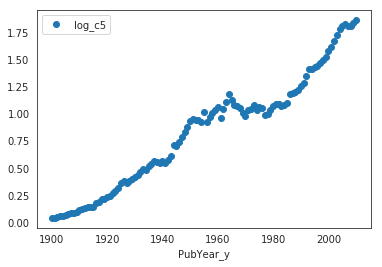

In [18]:
# variation of c5 counts with year
grouped_dfs.plot(x='PubYear_y', y='log_c5', style='o')

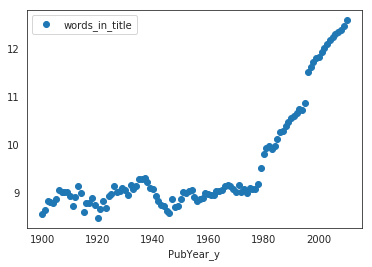

In [19]:
#variation of words_in_title with year
grouped_dfs.plot(x='PubYear_y', y='words_in_title', style='o')

In [20]:
# removing the stop words from the title
import nltk
stopwords = nltk.corpus.stopwords.words('english')

def remove_stopwords(s):  
    clean_title = ""
    try:
        s = str.lower(s)
        clean_title = " ".join([word for word in s.split() if word not in stopwords])
    except:
        pass
    return clean_title
        

data["title_without_stopwords"] = data['Title'].progress_apply(lambda x: remove_stopwords(x))
data[["Title", "title_without_stopwords"]].head()

Progress: 100%|██████████| 39171597/39171597 [14:24<00:00, 45327.01it/s]


,Title,title_without_stopwords
0,SPORADIC LEGIONELLOSIS IN THE UNITED-STATES - ...,sporadic legionellosis united-states - 1st tho...
1,REACTION OF LEAD PERCHLORATE WITH AMMONIUM HYD...,reaction lead perchlorate ammonium hydrophosph...
2,ELECTRICAL PACING FOR SHORT BOWEL SYNDROME,electrical pacing short bowel syndrome
3,STABILITY TESTING OF SOLID DRUGS USING PREFERE...,stability testing solid drugs using preferenti...
4,ON THE DETERMINATION OF THE 1ST NORMAL STRESS ...,determination 1st normal stress difference usi...


In [21]:
# average number of words in paper titles (excluding stopwords in a year)
data["words_in_title_without_stopwords"] = data["title_without_stopwords"].progress_apply(lambda x: count_words(x))

Progress: 100%|██████████| 39171597/39171597 [01:10<00:00, 551969.00it/s]


In [22]:
data[["words_in_title","words_in_title_without_stopwords"]].head()

,words_in_title,words_in_title_without_stopwords
0,10,7
1,9,6
2,6,5
3,19,14
4,14,9


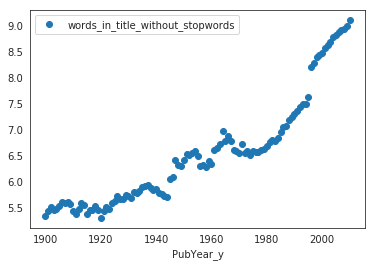

In [23]:
grouped_df_title_without_stopwords_per_year = data.groupby('PubYear_y', as_index=False)['words_in_title_without_stopwords'].mean()

#variation of words_in_title with year
#grouped_df_title_without_stopwords_per_year.head()
grouped_df_title_without_stopwords_per_year.plot(x='PubYear_y', y='words_in_title_without_stopwords', style='o')

In [ ]:
#Run and save this Later - todo - Sree

data.to_pickle("/mnt/disks/vault/citation-data-title-cleaned/c5-data-headlines-cleaned.pql")